### Hiểu về bộ dữ liệu
- Kiểm tra cấu trúc của tập dữ liệu (file .csv).
- File csv là như google sheet, nó lưu ảnh dưới dạng pixel trong 1 table, cột 1 là nhãn, cột 2 là tập pixel của ảnh dưới dạng số, cột 3 là sử dụng để train hay làm gì
- Xem số lượng mẫu, số cột, kích thước ảnh, và thông tin các nhãn cảm xúc.

In [2]:
import pandas as pd
df = pd.read_csv('../fer2013.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


### Kiểm tra phân phối dữ liệu
- Xem số lượng mẫu của từng nhãn cảm xúc:

C:\Users\USER\AppData\Local\Temp\ipykernel_4944\1385058805.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")


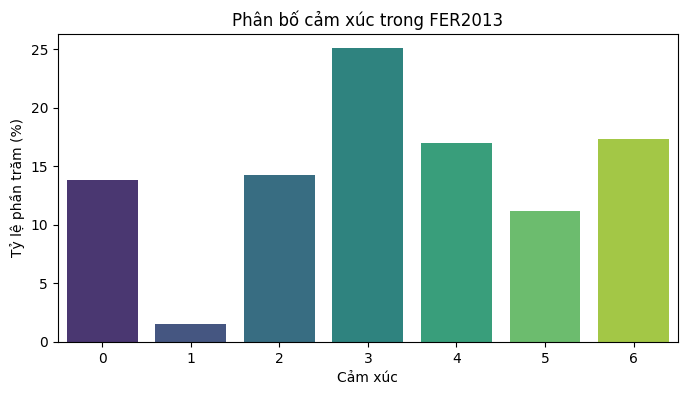

emotion
3    25.048068
6    17.270878
4    16.933709
2    14.269791
0    13.801655
5    11.151671
1     1.524229
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Tính toán tỷ lệ phần trăm
emotion_counts = df['emotion'].value_counts(normalize=True) * 100

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")
plt.xlabel("Cảm xúc")
plt.ylabel("Tỷ lệ phần trăm (%)")
plt.title("Phân bố cảm xúc trong FER2013")
plt.show()

# Hiển thị giá trị chi tiết
print(emotion_counts)

### Trực quan hóa ảnh mẫu
- Chuyển đổi dữ liệu pixel từ dạng chuỗi sang ma trận ảnh 48x48.
- Điều này giúp kiểm tra xem dữ liệu có bị nhiễu hay không (ví dụ: ảnh bị méo, thiếu dữ liệu).

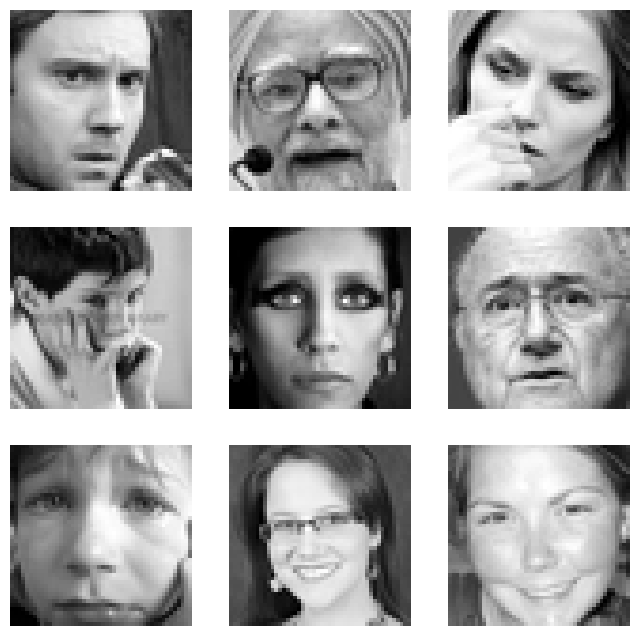

In [4]:
import numpy as np
import cv2

def string_to_image(pixel_str):
    pixels = np.array(pixel_str.split(), dtype='uint8').reshape(48, 48)
    return pixels

sample_images = [string_to_image(df.iloc[i]['pixels']) for i in range(9)]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.axis('off')
plt.show()

### Kiểm tra thống kê dữ liệu
- Tính toán giá trị trung bình, độ lệch chuẩn của từng ảnh để kiểm tra sự biến đổi:
- Nếu độ lệch chuẩn quá thấp, ảnh có thể quá đồng nhất → cần xem xét tiền xử lý như chuẩn hóa.

In [5]:
mean_pixel = np.mean(df['pixels'].apply(lambda x: np.mean(np.array(x.split(), dtype='float32'))))
std_pixel = np.mean(df['pixels'].apply(lambda x: np.std(np.array(x.split(), dtype='float32'))))

print(f'Mean pixel value: {mean_pixel}, Standard deviation: {std_pixel}')

Mean pixel value: 129.38584899902344, Standard deviation: 54.056968688964844


### Kiểm tra chất lượng dữ liệu
- Xác định dữ liệu bị thiếu hoặc lỗi
- Nếu có dữ liệu lỗi, có thể xóa hoặc xử lý trước khi huấn luyện mô hình.

In [6]:
print(df.isnull().sum())  # Kiểm tra giá trị thiếu
print(df.duplicated().sum())  # Kiểm tra trùng lặp

df = df.drop_duplicates()
print(f"Dữ liệu sau khi loại bỏ trùng lặp: {df.shape}")

emotion    0
pixels     0
Usage      0
dtype: int64
1234
Dữ liệu sau khi loại bỏ trùng lặp: (34653, 3)


### Kiểm tra độ sáng

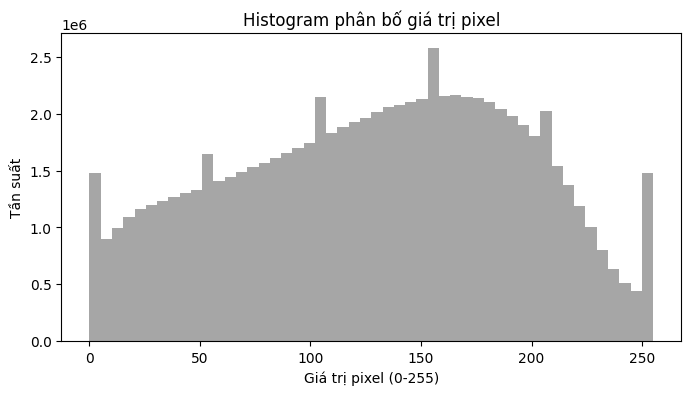

In [7]:
import numpy as np

# Chuyển đổi dữ liệu pixel sang mảng NumPy
all_pixels = np.hstack(df['pixels'].apply(lambda x: np.array(list(map(int, x.split())))))

# Vẽ histogram
plt.figure(figsize=(8, 4))
plt.hist(all_pixels, bins=50, color='gray', alpha=0.7)
plt.xlabel("Giá trị pixel (0-255)")
plt.ylabel("Tần suất")
plt.title("Histogram phân bố giá trị pixel")
plt.show()

### Tiền xử lý dữ liệu
- Chuẩn hóa pixel về khoảng [0, 1] hoặc [-1, 1] để giúp mô hình học tốt hơn bằng cách chia tất cả pixel cho 255 (255 là giá trị lớn nhất của ảnh 8 bit)
- Ảnh 8 bit: mỗi pixel có thể nhận 256 giá trị màu khác nhau. Ngoài ra còn có ảnh 16 bit dùng trong y khoa và 32 bit dùng trong đồ họa cao cấp RGBA có thể xử lý độ trong suốt
- Lý do chính:
    - Giúp mô hình học hiệu quả hơn: Giảm độ lệch giữa các giá trị đầu vào, giúp thuật toán hội tụ nhanh hơn.
    - Giảm ảnh hưởng của các giá trị lớn: Mạng nơ-ron hoạt động tốt hơn với dữ liệu nhỏ, tránh vấn đề mất ổn định số học.
    - Tối ưu hóa quá trình huấn luyện: Giảm sự chênh lệch giữa các feature, giúp gradient descent cập nhật tốt hơn.
#### Kết quả
- Bây giờ mỗi phần tử trong cột 'pixels' là một mảng NumPy chứ không còn là chuỗi nữa.
- Vd: array([0.2745, 0.3137, 0.3529, 0.3922, ...], dtype=float32)

In [8]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32') / 255.0)

- Chia tập dữ liệu thành train, validation, test:

In [9]:
from sklearn.model_selection import train_test_split

X = np.stack(df['pixels'].values)
y = df['emotion'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Kiểm tra mức độ tương đồng giữa các cảm xúc:
- Dùng PCA hoặc t-SNE để kiểm tra xem các lớp có bị chồng chéo không.

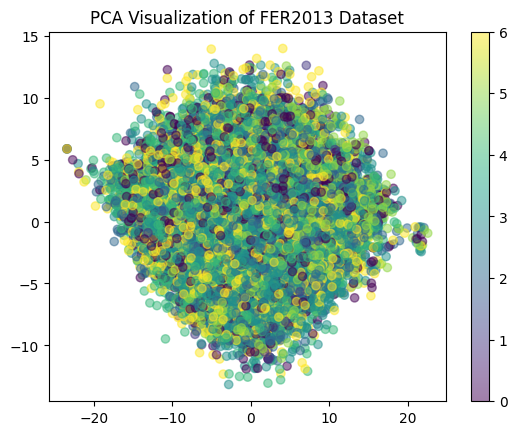

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.reshape(len(X_train), -1))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title("PCA Visualization of FER2013 Dataset")
plt.show()

### Nhận xét PCA
- Hình dạng phân bố dữ liệu
    - Các điểm dữ liệu phân bố thành một cụm rộng, không có sự tách biệt rõ ràng giữa các nhóm.
    - Điều này cho thấy dữ liệu không dễ dàng phân loại chỉ dựa trên PCA 2D, vì không có ranh giới rõ ràng giữa các cảm xúc.
    - Các điểm chồng lên nhau khá nhiều, chứng tỏ một số cảm xúc có mức độ tương đồng cao.

- Màu sắc và phân bố nhãn
    - Thanh màu (color bar) bên phải cho thấy dữ liệu được chia thành 7 lớp (từ 0 đến 6, tương ứng với các cảm xúc khác nhau).
    - Các điểm có màu sắc xen kẽ nhau, điều này chứng tỏ các cảm xúc có sự giao thoa, không phân tách dễ dàng trong không gian PCA 2D.
- Ý nghĩa về tính phân biệt của dữ liệu
    - Nếu mô hình machine learning sử dụng PCA 2D để phân loại, có thể hiệu suất sẽ không cao vì không có cụm nào rõ ràng.
    - PCA chỉ giúp giảm chiều dữ liệu để trực quan hóa, nhưng mô hình phân loại thực tế có thể cần dùng đến các kỹ thuật khác như mạng nơ-ron sâu (CNN) để trích xuất đặc trưng tốt hơn.